- Diana Zaray Corado #191025
- Pablo Alejandro Méndez #19195
- Orlando Osberto Cabrera #19943
# Hoja de Trabajo 6 - Modelo de Regresión Logística
                                                                                                                           

In [1]:
# Librerias
import pandas as pd
import numpy as np
import scipy.stats as sp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,r2_score, explained_variance_score, mean_absolute_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score,precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score ,precision_score,recall_score,f1_score
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Estilos
plt.style.use('ggplot')

In [3]:
# General functions
def calculate_frecuency(data, column, index='index', head = False):
    data_f = pd.DataFrame({
        'frecuency': data[column].value_counts(),
        'relative_frecuency (%)': data[column].value_counts(normalize=True)*100,
        'relative_acc_frecuency': data[column].value_counts(normalize=True).cumsum()
    })
    data_f.reset_index(level=[0], inplace=True)
    data_f.rename(columns={index:column}, inplace=True)
    if head:
        left_aligned_df = data_f.head(20).style.set_properties(**{'text-align': 'center'}) 
    else:
        left_aligned_df = data_f.style.set_properties(**{'text-align': 'center'})
    display(left_aligned_df)
    return data_f


In [4]:
# General variables
cuantitative = [
    'LotFrontage',
    'LotArea',
    'MiscVal',
	'WoodDeckSF',
    'OpenPorchSF',
    'EnclosedPorch',
    '3SsnPorch',
    'ScreenPorch',
    'PoolArea',
    'GarageArea',
    'GrLivArea',
    'LowQualFinSF',
    '2ndFlrSF',
    '1stFlrSF',
    'TotalBsmtSF',
    'BsmtUnfSF',
    'BsmtFinSF2',
    'BsmtFinSF1',
    'MasVnrArea',
    'BsmtFullBath',
    'BsmtHalfBath',
    'FullBath',
    'HalfBath',
    'KitchenAbvGr',
    'TotRmsAbvGrd',
    'Fireplaces',
    'GarageCars',
    'SalePrice',
]

# Exploración de los datos
Análisis exploratorio de los datos para obtener un mejor conocimiento sobre los mismos y su distribución. Se trabajará con un set de datos proporcionado por Kaggle denominado House Prices: Advance Regression Techniques.s.

In [5]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
train_shape = train.shape
test_shape = test.shape

print(f'Los datos de entrenamiento cuenta con {train_shape[0]} observaciones y {train_shape[1]} variables.\nDe igual forma, los datos de prueba tienen {test_shape[0]} observaciones y {train_shape[1]} variables')

Los datos de entrenamiento cuenta con 1460 observaciones y 81 variables.
De igual forma, los datos de prueba tienen 1459 observaciones y 81 variables


In [6]:
# Resumen de los datos
head = train.head().style.set_properties(**{'text-align': 'center'}) 
display(head)
del head

Se decidió omitir la parte de exploración de los datos debido a que esta ya ha sido elaborada y presentada en hojas de trabajo anteriores

## Preprocesamiento
Para el preprocesamiento de los datos se procede a validar si existen observaciones con valores faltantes o si es necesaria una normalización de las mismas. Así como la selección de las variables que se utilizaran como predictoras dentro del modelo. Algo importante a tomar en consideración es que debido a que es una regresión logísitica, el modelo solo puede trabajar con variables cuantitativas, por lo tal, como predictores se acotará el rango de variables a únicamente las cuantitativas.

In [7]:
select_train = train[cuantitative]

### Tratamiento de valores NA


In [8]:
# Asegurando que no existan valores nan o inf
select_train = select_train[~select_train.isin([np.nan, np.inf, -np.inf]).any(1)]

## Estandarización de las variables

In [9]:
scaler = StandardScaler().fit(select_train)
train_std = scaler.transform(select_train)

# Datos de entrenamiento y prueba
Selección de las variables a utilizar dentro del modelo de regresión logística, y para ello se utiliza la correlación entre las variables cuantitativas. Por otro lado, también se introducen a las observaciones las variables dicotómicas, determinadas por la clasificación realizada en los árboles de decisión de casas caras, intermedias y económicas.

## Selección de variables
Para seleccionar las variables a utilizar dentro del modelo, se inició tomando en consideración únicamente las variables numéricas. Seguido a esto, se realizó una correlación entre todas las variables cuantitativas para poder analizar cuáles son las que influyen significativamente en el precio de venta, y con base a esto se seleccionó el conjunto de features a utilizar.

In [10]:
important_correlations = []
corr = train[cuantitative].corr(method='spearman')

for start, h1 in enumerate(cuantitative):
    for h2 in cuantitative[start + 1:]:
        if abs(corr[h1][h2]) > 0.5:
            important_correlations.append((h1, h2, corr[h1][h2]))


data = pd.DataFrame(important_correlations, columns=("Variable1", "Variable2", "Correlación"))
data_f = data.style.set_properties(**{'text-align': 'center'}) 
display(data_f)

del start, h1, h2, corr, data, data_f

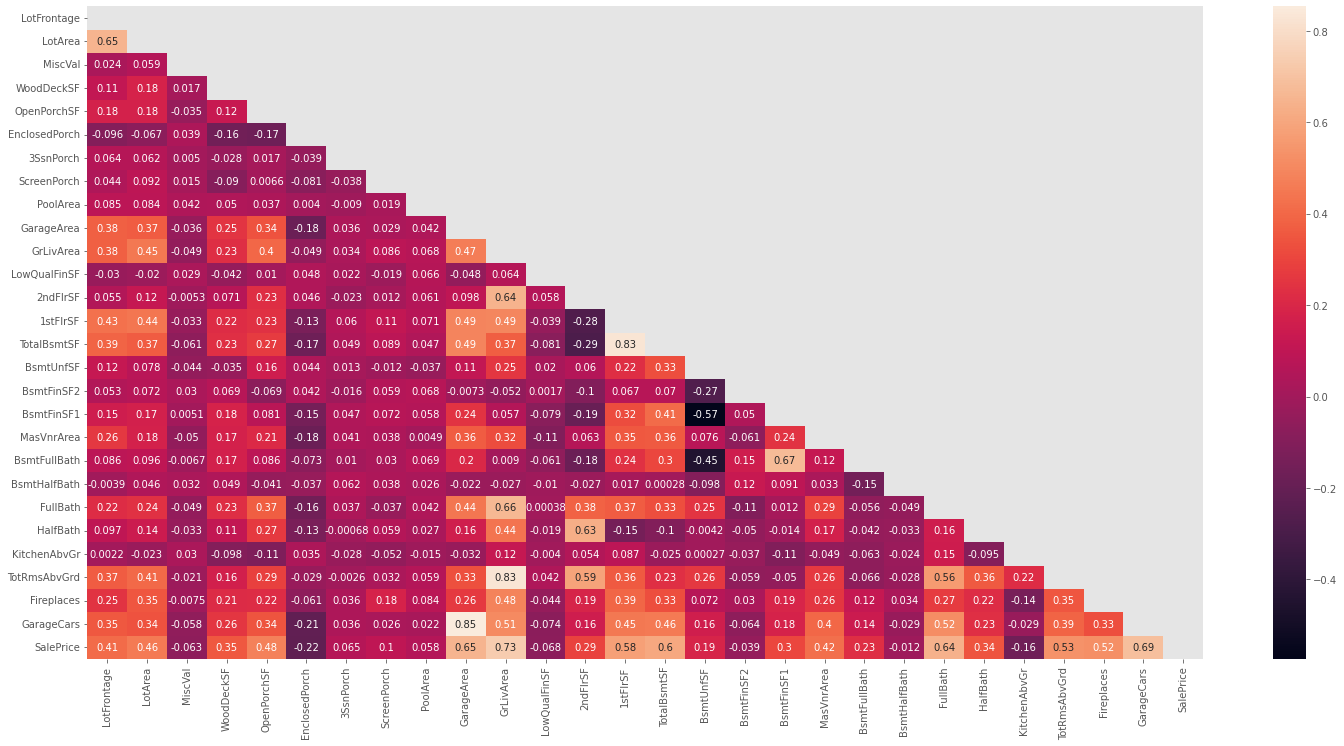

In [11]:
cuantitative_data = train[cuantitative]
correlation = cuantitative_data.corr(method = 'spearman')
plt.figure(figsize=(25,12))
matrix = np.triu(correlation)
sns.heatmap(correlation, annot=True, mask=matrix)
plt.show()

del correlation, cuantitative_data, matrix

Como se puede observar en la tabla y gráfica anterior se presentan aquellas variables que cuentan con una alta correlación (tomando como correlación alta a valores mayores o iguales a 0.5). A continuación se listan la correlaciones encontradas por variables:
- LotFrontage → LotArea
- GarageArea → GarageCars, SalePrice
- GrLivArea → 2ndFlrSF, FullBath, TotRmsAbvGrd, GarageCars, SalePrice
- 2ndFlrSF → HalfBath, TotRmsAbvGrd
- 1stFlrSF → TotalBsmtSF, SalePrice
- TotalBsmtSF → SalePrice
- BsmtUnfSF → BsmtFinSF1, BsmtFullBath
- FullBath → TotRmsAbvGrd, GarageCars, SalePrice
- TotRmsAbvGrd → SalePrice
- Fireplaces → SalePrice
- GargeCars → SalePrice

La estrecha correlación con la que cuentan las variables entre sí representa un potencial error para el modelo, ya que como bien se sabe, uno de los supuestos dentro del modelo de regresión logísticas es que las variables no presenten multicolinealidad ya que esto podría sesgar dicho modelo a la información "repetida" presentada por estas variables. Por lo tal, para evitar un sesgo y *overfitting* del modelo se eliminaran las variables correlacionadas, dejando solo una que represente la información de todas dentro del modelo. Las variables que se descartarán del modelo son:
- LotFrontage
- GarageCars
- TotRmsAbvGrd
- FullBath
- HalfBath
- TotalBsmtSF
- BsmtFinSF1
- BsmFullBath
- Fireplaces


In [12]:
useless = ['LotFrontage', 
'GarageCars', 
'TotRmsAbvGrd', 
'FullBath', 
'HalfBath', 
'TotalBsmtSF', 
'BsmtFinSF1', 
'BsmtFullBath', 
'Fireplaces', 
'PoolArea', 
'LowQualFinSF', 
'BsmtFinSF2', 
'BsmtHalfBath', 
'KitchenAbvGr' ]

### Variables dicotómicas

In [13]:
# Agregando la nueva variable al data frame
cheap = [
    (select_train['SalePrice'] <= 171500),
    ]

intermediate = [
    (select_train['SalePrice'] > 171500) & (select_train['SalePrice'] <= 295500),
    ]

expensive = [
    (select_train['SalePrice'] > 295500) 
    ]

values = [1]
select_train['Cheap'] = np.select(cheap, values)

select_train['Intermediate'] = np.select(intermediate, values)

select_train['Expensive'] = np.select(expensive, values)

del values, cheap, intermediate, expensive

In [14]:
selected_train = select_train.loc[:, ~select_train.columns.isin(useless)]

In [15]:
expensive_target = selected_train.pop('Expensive')
intermediate_target = selected_train.pop('Intermediate')
cheap_target = selected_train.pop('Cheap')
predictors = selected_train

In [16]:
# stratified sample for expensive houses
predictors_train, predictors_test, target_train, target_test = train_test_split(predictors, expensive_target, train_size  = 0.7, shuffle = True, random_state=19195)

# Regresión logística -Caras-
Elabore un modelo de regresión logística para conocer si una vivienda es cara o no, utilizando el conjunto de entrenamiento y explique los resultados a los que llega. Muestre el modelo gráficamente. El experimento debe ser reproducible por lo que debe fijar que los conjuntos de entrenamiento y prueba sean los mismos siempre que se ejecute el código.

In [17]:
model = sm.Logit(endog=target_train, exog=predictors_train, )
model = model.fit()
print(model.summary())

         Current function value: 0.153383
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:              Expensive   No. Observations:                  836
Model:                          Logit   Df Residuals:                      822
Method:                           MLE   Df Model:                           13
Date:                Sun, 17 Apr 2022   Pseudo R-squ.:                  0.5180
Time:                        19:17:22   Log-Likelihood:                -128.23
converged:                      False   LL-Null:                       -266.01
Covariance Type:            nonrobust   LLR p-value:                 3.058e-51
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
LotArea       -1.613e-05   1.03e-05     -1.564      0.118   -3.63e-05    4.08e-06
MiscVal          -0.1069    134.723     -0.001      0.99

En el resumen del modelo generado anteriormente se puede observar que, en su mayoría, una casa sea clasificada como cara está relacionada negativamente con los predictores seleccionados (esto se puede ver en los coeficientes de la regresión, como LotArea), si bien, existen aquellos en los cuales la relación es positiva, sin embargo esta no es el tipo de relación predominante.

Al igual que en el caso de la regresión lineal, en la regresión logística se puede validar la significancia del modelo creado por medio del LLR p-value, como bien se sabe, el p-value permite conocer la certeza que se espera en los resultados, o el porcentaje que se espera que los resultados no sean correctos. Como se puede observar, el valor obtenido para el modelo es de 3.058e-51 lo que permite asegurar que la regresión puede crear una representación significativa de los datos.

Por otro lado, algo importante a destacar es la significancia de los predictores, al igual que en el caso de la regresión lineal, este se mide por el p-value de cada predictor, y en general se considera que aquellos que tienen un p-value mayor a 0.05 no aportan significativamente al modelo, por lo tal, en busca de mejorar el modelo creado, se eliminaran aquellas variables cuyo p-value este por encima de 0.05.

In [18]:
new_useless = ['MiscVal', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch','GrLivArea', '2ndFLrSF', 'BsmtUnfSF']
predictors_train = predictors_train.loc[:, ~predictors_train.columns.isin(new_useless)]
predictors_test = predictors_test.loc[:, ~predictors_test.columns.isin(new_useless)]

In [19]:
model = sm.Logit(endog=target_train, exog=predictors_train)
model = model.fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.158159
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              Expensive   No. Observations:                  836
Model:                          Logit   Df Residuals:                      829
Method:                           MLE   Df Model:                            6
Date:                Sun, 17 Apr 2022   Pseudo R-squ.:                  0.5029
Time:                        19:17:22   Log-Likelihood:                -132.22
converged:                       True   LL-Null:                       -266.01
Covariance Type:            nonrobust   LLR p-value:                 7.143e-55
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
LotArea     -1.556e-05      1e-05     -1.554      0.120   -3.52e-05    4.06e-06
ScreenPorch    -0.0058    

Al remover del modelo las variables que por su significancia no aportaban información relevante al modelo y entrenar nuevamente el modelo, se puede observar que si bien, el valor de pseudo R-squ ha disminuído en una unidad con respecto al modelo anterior, el p-value también ha disminuído, y con ello garantizando que este modelo tiene un menor porcentaje de otorgar resultados creados al azar.

### Representación gráfica del modelo

Predictors
0  -6742.084441
1 -96240.788318
2  -8197.190619
3 -67243.812910
4 -63561.304524

<AxesSubplot:xlabel='Predictors', ylabel='Expensive'>

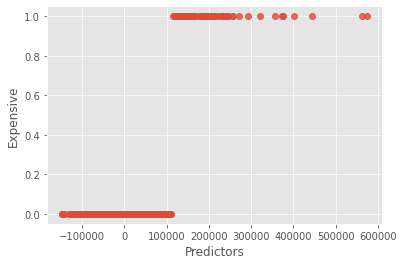

In [20]:
pca = PCA(n_components=1) # 2D projection
principal_components = pca.fit_transform(predictors_train)
pca_train_2d = pd.DataFrame(data = principal_components, columns = ['Predictors'])
display(pca_train_2d.head())
del pca, principal_components
#plot logistic regression curve
sns.regplot(x=pca_train_2d, y=target_train, logistic=True, ci=None)

# Análisis del modelo
Analice el modelo. Determine si hay multicolinealidad en las variables, y cuáles son las que aportan al modelo, por su valor de significación. Haga un análisis de correlación de las variables del modelo y especifique si el modelo se adapta bien a los datos. Explique si hay sobreajuste (overfitting) o no. En caso de existir sobreajuste, haga otro modelo que lo corrija.

### Multicolinealidad y significancia
La multicolinealidad se define como la correlación alta existente entre dos o más variables predictoras. Para esta hoja de trabajo y para este apartado en particular, se considera como correlación alta a aquella correlación con un valor por arriba de 0.85

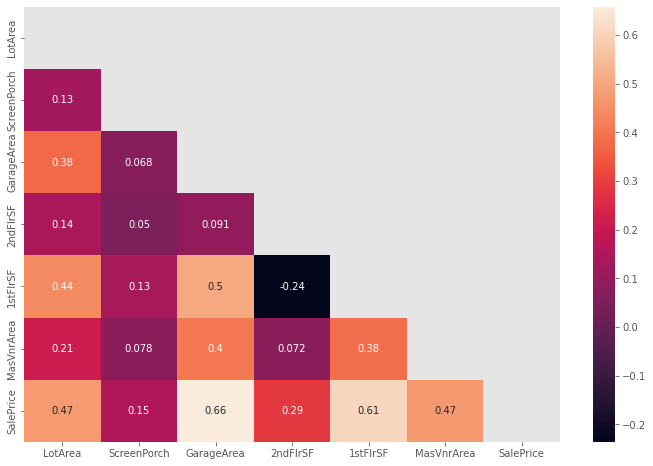

In [21]:
correlation = predictors_train.corr(method = 'spearman')
plt.figure(figsize=(12,8))
matrix = np.triu(correlation)
sns.heatmap(correlation, annot=True, mask=matrix)
plt.show()

del correlation, matrix

Como se puede observar en el mapa de calor anterior, no existe multicolineal entre las variables utilizadas para entrenar el modelo, ya que desde el apartado de selección de datos de prueba y entrenamiento estos fueron descartados para evitar sesgo.

In [22]:
model.pvalues

LotArea        1.201482e-01
ScreenPorch    5.662800e-02
GarageArea     5.326871e-08
2ndFlrSF       2.000282e-22
1stFlrSF       3.750421e-28
MasVnrArea     4.440193e-03
SalePrice      8.631026e-26
dtype: float64

De acorde al valor de significancia, *p-value*, obtenido en el resumen del modelo elaborado se sabe que en ningún caso se acepta la hipótesis nula planteada, la cual indica que el predictor no contribuye al modelo en presencia del resto de predictores. Por lo tal, con base en los *p-value* obtenidos se sabe que todos los *features* aportan significativamente al modelo

### Validación de overfitting
Para validar si en el modelo existe overfitting se realizará un análisis de matriz de confusión para predecir los valores de entrenamiento y los de test creados en apartados anteriores.

In [23]:
# Predicción con los datos de training
prediction_train = model.predict(predictors_train)
prediction_train = list(map(round, prediction_train))
prediction_test = model.predict(predictors_test)
prediction_test = list(map(round, prediction_test))

In [24]:
data = pd.DataFrame({
    'Prediction': prediction_train,
    'Real': target_train
})
display(data.head(20))
del data

Prediction  Real
799            0     0
976            0     0
670            0     0
51             0     0
441            0     0
1224           0     0
630            0     0
449            0     0
73             0     0
139            0     0
1406           0     0
174            0     0
902            0     0
367            0     0
272            0     0
1414           0     0
474            0     0
550            0     0
99             0     0
1063           0     0

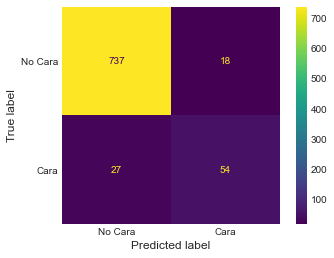

In [25]:
plt.style.use('seaborn-dark')
cm_train = confusion_matrix(target_train, prediction_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['No Cara', 'Cara'])
disp.plot()
plt.show()
del cm_train

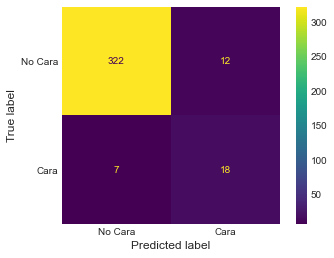

In [26]:
plt.style.use('seaborn-dark')
cm_test = confusion_matrix(target_test, prediction_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['No Cara', 'Cara'])
disp.plot()
plt.show()

Con los gráficos anteriores se puede inferir que no existe *overfitting* en el modelo, ya que tanto para los datos de entrenamiento como para los datos de prueba, los residuos del modelo no se encuentran distribuídos al azar, sino por su parte, la distribución parece ser en forma de abanico. Ninguna de las 2 predicciones, basado en los gráficos anteriores, parece predecir relativamente, de mejor manera si la casa es cara o no.

# Eficiencia del algoritmo
Utilice el modelo con el conjunto de prueba y determine la eficiencia del algoritmo para predecir el precio de las casas. 

In [27]:
target_names = ['No cara', 'Cara']
print(classification_report(target_test, prediction_test, target_names=target_names))

              precision    recall  f1-score   support

     No cara       0.98      0.96      0.97       334
        Cara       0.60      0.72      0.65        25

    accuracy                           0.95       359
   macro avg       0.79      0.84      0.81       359
weighted avg       0.95      0.95      0.95       359



En el resumen anterior se puede observar que el modelo es menos preciso al clasificar las casas como caras que como no caras, ya que tan solo el 63% de las predicciones de realizó de manera correcta, a diferencia de las clasificaciones como casas no caras, en las cuales se cuenta con una precisión del 98%. 

Por otro lado, en el caso de la métrica de *recall* esta permite estimar qué tan sensible es el modelo para predecir TODOS los casos correctamente. Es decir, es la habilidad del modelo para encontrar TODAS las casas de un tipo particular. Por ejemplo, en el caso de las casas caras se sabe que del 100% de casas de este tipo, solo pudo clasificar un 76% correctamente. 

Con el *f1_score* es otra forma de evaluar la exactitud del modelo, que incluso en más certera que la exactitud global, ya que esta toma en cuenta la precisión y sensibilidad del modelo. En este caso se puede ver que la exactitud en cuanto al *f1_score* para la clasificación de una casa como caras es de 69%, lo cual no es un valor muy alto, pero al menos asegura que es mejor que hacer predicciones al azar.

Es interesante notar que a pesar de que el modelo no sea muy bueno prediciendo las casas de tipo caras, este cuenta con un *accuracy* del 95% lo cual en general indica que el modelo es bueno prediciendo los datos, sin embargo es importante indicar que este valor no toma en consideración los sesgos que puedan existir en los datos. Es por ello que mejor se mide la exactitud del modelo mediante el *f1-score*.

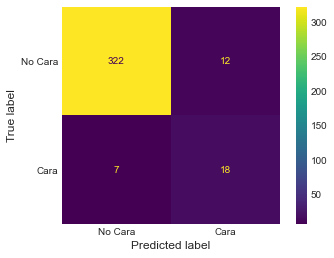

In [28]:
disp.plot()
plt.show()

Con la matrix de confusión mostrada anteriormente es fácil notar que el modelo se equivocó más en reconocer si una casa es cara  en contraste con reconocer que una casa no sea cara. Esto puede deberse a que dentro del data set de entrenamiento se tenía una mayor cantidad de casas no caras que de caras, por lo que el modelo aprendió a recnocer este tipo de casas más fácilmente. Por otro lado, también se puede notar cómo la sensibilidad o *recall* está asociado a la cantidad de errores que comete en las predicciones, está estrechamente relacionada con la información mostrada por la matriz de confusión. 

Los errores dentro del modelo dan la capacidad de encontrar estrategias que permitan entrenar de mejor forma el mismo, como se mencionó anteriormente los errores dentro del conjunto de datos pueden ser consecuencia del sesgo obtenido en los datos, por lo tal, una forma de asegurar un mejor aprendizaje por medio del modelo sería realizar una muestro balanceado.

# Regresión logística -Intermedias-


In [29]:
# stratified sample for intermediate houses
predictors_train, predictors_test, target_train, target_test = train_test_split(predictors, intermediate_target, train_size  = 0.7, shuffle = True, random_state=19195)
new_useless = ['MiscVal', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch','GrLivArea', '2ndFLrSF', 'BsmtUnfSF']
predictors_train = predictors_train.loc[:, ~predictors_train.columns.isin(new_useless)]
predictors_test = predictors_test.loc[:, ~predictors_test.columns.isin(new_useless)]

In [30]:
model = sm.Logit(endog=target_train, exog=predictors_train)
model = model.fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.638537
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           Intermediate   No. Observations:                  836
Model:                          Logit   Df Residuals:                      829
Method:                           MLE   Df Model:                            6
Date:                Sun, 17 Apr 2022   Pseudo R-squ.:                 0.01533
Time:                        19:17:24   Log-Likelihood:                -533.82
converged:                       True   LL-Null:                       -542.13
Covariance Type:            nonrobust   LLR p-value:                   0.01078
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
LotArea      -2.69e-05   1.73e-05     -1.551      0.121   -6.09e-05    7.08e-06
ScreenPorch     0.0015    

En el resumen del modelo generado anteriormente se puede observar que la clasificación de una casa como intermedia, con sus predictores, está de igual forma relacionada tanto negativa como positivamente. Para este modelo elaborado, el valor de *LLR p-value*, con un valor de 0.010078, es mucho mayor que el obtenido para el modelo de las casas caras, el cual tenía un valor de 3.058e-51, por lo tal, debido a que aún es menor al valor de significancia definido se puede asegurar que la regresión puede crear una representación significativa de los datos teniendo un bajo porcentaje de tener resultados incorrectos.

Como se puede observar en la significancia de cada uno de los predictores, existen algunos que para este modelo en particular se consideran que no aportan significativamente al modelo, sin embargo, debido a que uno de los propósitos de esta hoja de laboratorio es la comparación entre los distintos modelos creados, para poder hacer una comparación objetiva los modelos deben de crearse con los mismos predictores. Por lo tal, no se eliminan los predictores con altos valores de *p-value*.


### Representación gráfica del modelo

In [31]:
pca = PCA(n_components=1) # 2D projection
principal_components = pca.fit_transform(predictors_train)
pca_train_2d = pd.DataFrame(data = principal_components, columns = ['Predictors'])
display(pca_train_2d.head())
del pca, principal_components

Predictors
0  -6742.084441
1 -96240.788318
2  -8197.190619
3 -67243.812910
4 -63561.304524

<AxesSubplot:xlabel='Predictors', ylabel='Intermediate'>

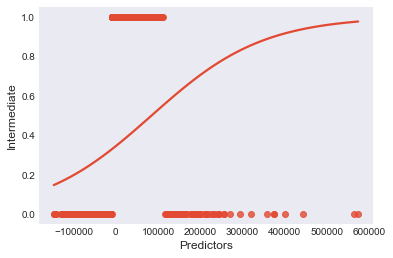

In [32]:
#plot logistic regression curve
sns.regplot(x=pca_train_2d, y=target_train, logistic=True, ci=None)

# Análisis del modelo

### Multicolinealidad y significancia

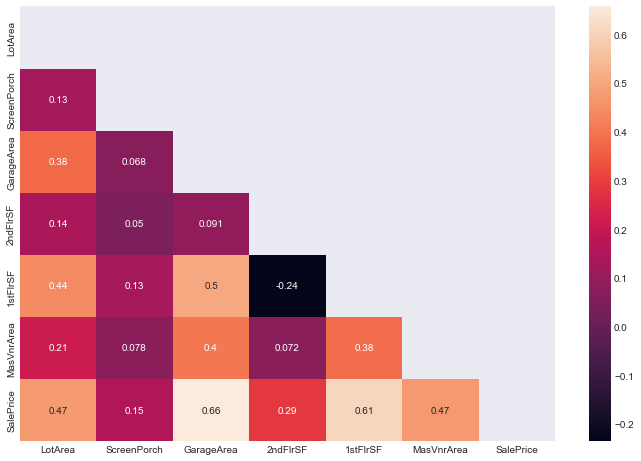

In [33]:
correlation = predictors_train.corr(method = 'spearman')
plt.figure(figsize=(12,8))
matrix = np.triu(correlation)
sns.heatmap(correlation, annot=True, mask=matrix)
plt.show()

del correlation, matrix

Es importante mencionar que se toma como valor de correlación significativa aquellos valores por arriba de 0.85, por lo tal, como se puede observar en el mapa de calor anterior, no existe multicolineal entre las variables utilizadas para entrenar el modelo, ya que desde el apartado de selección de datos de prueba y entrenamiento estos fueron descartados para evitar sesgo.

In [34]:
model.pvalues

LotArea        1.207947e-01
ScreenPorch    2.096364e-01
GarageArea     5.882873e-03
2ndFlrSF       8.536465e-01
1stFlrSF       1.067903e-09
MasVnrArea     6.582506e-01
SalePrice      2.630254e-04
dtype: float64

De acorde al valor de significancia, p-value, obtenido en el resumen del modelo elaborado se sabe que en ningún caso se acepta la hipótesis nula planteada, la cual indica que el predictor no contribuye al modelo en presencia del resto de predictores. Por lo tal, con base en los p-value obtenidos se sabe que todos los features aportan significativamente al modelo

### Validación de overfitting

In [35]:
# Predicción con los datos de training
prediction_train = model.predict(predictors_train)
prediction_train = list(map(round, prediction_train))
prediction_test = model.predict(predictors_test)
prediction_test = list(map(round, prediction_test))

In [36]:
data = pd.DataFrame({
    'Prediction': prediction_train,
    'Real': target_train
})
display(data.head(20))
del data

Prediction  Real
799            0     1
976            0     0
670            1     1
51             0     0
441            0     0
1224           0     1
630            0     0
449            0     0
73             0     0
139            1     1
1406           0     0
174            0     1
902            1     1
367            0     0
272            1     1
1414           0     1
474            0     1
550            0     0
99             0     0
1063           0     0

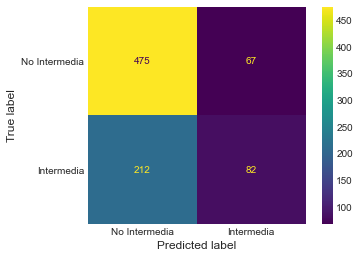

In [37]:
plt.style.use('seaborn-dark')
cm_train = confusion_matrix(target_train, prediction_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['No Intermedia', 'Intermedia'])
disp.plot()
plt.show()
del cm_train

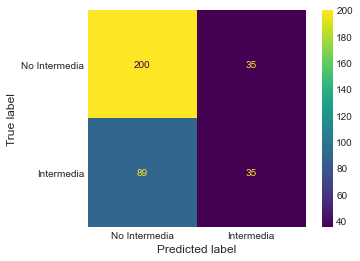

In [38]:
plt.style.use('seaborn-dark')
cm_test = confusion_matrix(target_test, prediction_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['No Intermedia', 'Intermedia'])
disp.plot()
plt.show()

Con los gráficos anteriores se puede inferir que no existe overfitting en el modelo, ya que tanto para los datos de entrenamiento como para los datos de prueba, los residuos del modelo no se encuentran distribuídos al azar, sino por su parte, la distribución parece ser en forma de abanico. Ninguna de las 2 predicciones, basado en los gráficos anteriores, parece predecir relativamente, de mejor manera si la casa es cara o no.

# Eficiencia del algoritmo

In [39]:
target_names = ['No Intermedia', 'Intermedia']
print(classification_report(target_test, prediction_test, target_names=target_names))

               precision    recall  f1-score   support

No Intermedia       0.69      0.85      0.76       235
   Intermedia       0.50      0.28      0.36       124

     accuracy                           0.65       359
    macro avg       0.60      0.57      0.56       359
 weighted avg       0.63      0.65      0.62       359



En el resumen anterior se puede observar que el modelo es menos preciso al clasificar las casas como intermedias que como no intermedias, ya que tan solo el 50% de las predicciones se realizarón de manera correcta, a diferencia de las clasificaciones como casas no intermedias, en las cuales se cuenta con una precisión del 69%. Si bien esta diferencia no es exageradamente significativa, ya que como se puede observar en el valor de *accuracy* del modelo en general, el cual es de 65%, este valor es bastante bajo, lo que puede sugerir que el modelo no se ajusta correctamente a los datos. Por otro lado, también se tiene la métrica de la sensibilidad del modelo, y en este caso se puede notar que del total de casas identificadas como intermedias, el modelo únicamente fue capaz de reconocer un 28% de estas.  

Como bien se mencionó, el el *f1-score* es otro método para evaluar la exactitud, y este en conjunto con la sensibilidad demuestran que en efecto el modelo es muy poco exacto, 28%, para predecir si la casa es intermedia.

En este caso, debido a que el modelo no es muy exacto en predecir si la casa es intermedia o no, esto afecta en conjunto a la precisión global del modelo, lo cual se ve reflejado en el valor de *accuracy* obtenido.

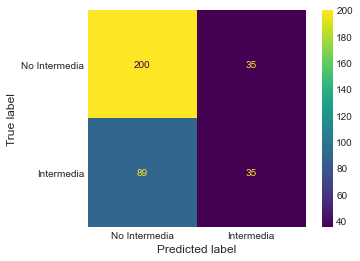

In [40]:
disp.plot()
plt.show()

De la mano con lo mencionado anteriormente, con la matrix de confusión se puede observar que el modelo se equivoca significativamente al indicar si la casa es intermedia. Esto es interesante y como se mencionó anteriormente puede deberse a las variables seleccionadas como predictoras para este conjunto de datos, sin embargo, algo también interesante a notar es que el error cometido al clasificar casas como no intermedias no es tan alto como al clasificarlas como intermedias, y de igual forma que con el modelo anterior esto puede deberse a que en conjunto existe una mayor cantidad de casas no intermedias que casas intermedias, y esto de cierta manera puede representar un sesgo dentro del conjunto de datos.

# Regresión logística -Baratas-

In [41]:
# stratified sample for cheap houses
predictors_train, predictors_test, target_train, target_test = train_test_split(predictors, cheap_target, train_size  = 0.7, shuffle = True, random_state=19195)
new_useless = ['MiscVal', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch','GrLivArea', '2ndFLrSF', 'BsmtUnfSF']
predictors_train = predictors_train.loc[:, ~predictors_train.columns.isin(new_useless)]
predictors_test = predictors_test.loc[:, ~predictors_test.columns.isin(new_useless)]

In [42]:
model = sm.Logit(endog=target_train, exog=predictors_train)
model = model.fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.444480
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Cheap   No. Observations:                  836
Model:                          Logit   Df Residuals:                      829
Method:                           MLE   Df Model:                            6
Date:                Sun, 17 Apr 2022   Pseudo R-squ.:                  0.3538
Time:                        19:17:26   Log-Likelihood:                -371.58
converged:                       True   LL-Null:                       -575.04
Covariance Type:            nonrobust   LLR p-value:                 9.139e-85
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
LotArea      2.552e-05   9.55e-06      2.673      0.008    6.81e-06    4.42e-05
ScreenPorch    -0.0010    

En el resumen del modelo generado anteriormente se puede observar que la clasificación de una casa como barata, con sus predictores, se encuentra mayormente realcionada de forma positiva que negativa, si bien esto dentro del modelo no representa un cambio significativo, sino más bien indica cómo afecta una variable a la otra.  Para este modelo elaborado, el valor de *LLR p-value*, con un valor de 9.139e-85, el cual de todos los modelos generados es el más pequeño, lo que permite inferir que se obtendrá una menor cantidad de errores al momento de elaborar la predicción.

Como se puede observar en la significancia de cada uno de los predictores, existen algunos que para este modelo en particular se consideran que no aportan significativamente al modelo, sin embargo, debido a que uno de los propósitos de esta hoja de laboratorio es la comparación entre los distintos modelos creados, para poder hacer una comparación objetiva los modelos deben de crearse con los mismos predictores. Por lo tal, no se eliminan los predictores con altos valores de *p-value*.

Algo interesante de este modelo y en contraste con el modelo anterior es el valor de *Pseudo R-squ* ya que este indica qué tan bien se ajusta el modelo a los datos, por tal valor, debido a que es mayor al del modelo anterior, se espera que este modelo sea mejor prediciendo las casas que son baratas y las que no.

### Representación gráfica del modelo

In [43]:
pca = PCA(n_components=1) # 2D projection
principal_components = pca.fit_transform(predictors_train)
pca_train_2d = pd.DataFrame(data = principal_components, columns = ['Predictors'])
display(pca_train_2d.head())
del pca, principal_components

Predictors
0  -6742.084441
1 -96240.788318
2  -8197.190619
3 -67243.812910
4 -63561.304524

<AxesSubplot:xlabel='Predictors', ylabel='Cheap'>

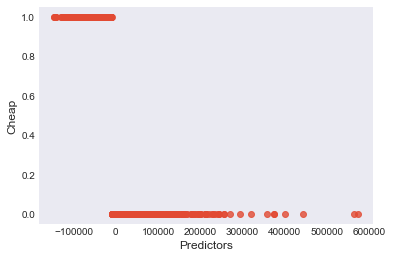

In [44]:
#plot logistic regression curve
sns.regplot(x=pca_train_2d, y=target_train, logistic=True, ci=None)

# Análisis del modelo

### Multicolinealidad y significancia

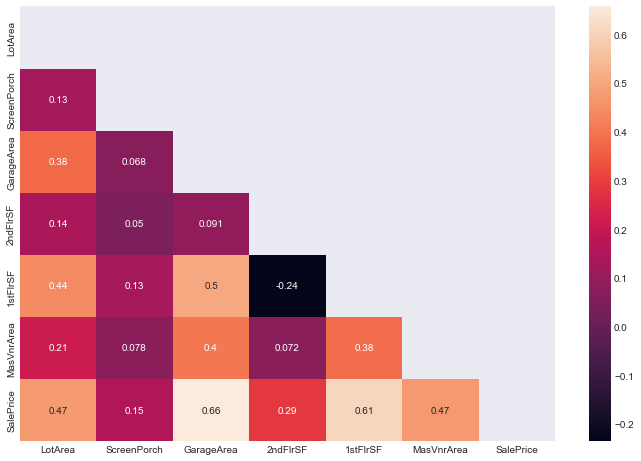

In [45]:
correlation = predictors_train.corr(method = 'spearman')
plt.figure(figsize=(12,8))
matrix = np.triu(correlation)
sns.heatmap(correlation, annot=True, mask=matrix)
plt.show()

del correlation, matrix

Es importante mencionar que se toma como valor de correlación significativa aquellos valores por arriba de 0.85, por lo tal, como se puede observar en el mapa de calor anterior, no existe multicolineal entre las variables utilizadas para entrenar el modelo, ya que desde el apartado de selección de datos de prueba y entrenamiento estos fueron descartados para evitar sesgo.

In [46]:
model.pvalues


LotArea        7.519533e-03
ScreenPorch    4.956674e-01
GarageArea     3.826298e-03
2ndFlrSF       6.053332e-12
1stFlrSF       8.820120e-37
MasVnrArea     2.068230e-02
SalePrice      8.147527e-34
dtype: float64

De acorde al valor de significancia, p-value, obtenido en el resumen del modelo elaborado se sabe que en ningún caso se acepta la hipótesis nula planteada, la cual indica que el predictor no contribuye al modelo en presencia del resto de predictores. Por lo tal, con base en los p-value obtenidos se sabe que todos los features aportan significativamente al modelo.

### Validación de overfitting

In [47]:
# Predicción con los datos de training
prediction_train = model.predict(predictors_train)
prediction_train = list(map(round, prediction_train))
prediction_test = model.predict(predictors_test)
prediction_test = list(map(round, prediction_test))

In [48]:
data = pd.DataFrame({
    'Prediction': prediction_train,
    'Real': target_train
})
display(data.head(20))
del data

Prediction  Real
799            0     0
976            1     1
670            0     0
51             1     1
441            1     1
1224           0     0
630            1     1
449            0     1
73             1     1
139            0     0
1406           0     1
174            1     0
902            0     0
367            1     1
272            0     0
1414           0     0
474            0     0
550            1     1
99             1     1
1063           1     1

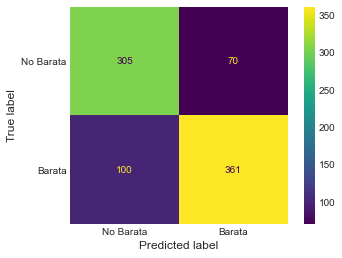

In [49]:
plt.style.use('seaborn-dark')
cm_train = confusion_matrix(target_train, prediction_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['No Barata', 'Barata'])
disp.plot()
plt.show()
del cm_train

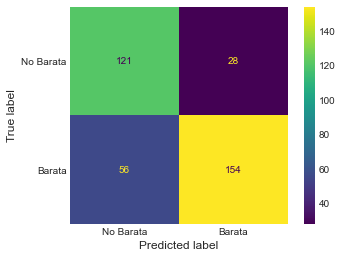

In [50]:
plt.style.use('seaborn-dark')
cm_test = confusion_matrix(target_test, prediction_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['No Barata', 'Barata'])
disp.plot()
plt.show()

Con los gráficos anteriores se puede inferir que no existe overfitting en el modelo, ya que tanto para los datos de entrenamiento como para los datos de prueba, los residuos del modelo no se encuentran distribuídos al azar, sino por su parte, la distribución parece ser en forma de abanico. Ninguna de las 2 predicciones, basado en los gráficos anteriores, parece predecir relativamente, de mejor manera si la casa es cara o no. Otra forma de notar que los errores y aciertos realizados por el modelo son proporcionales en los datos de entrenamiento y prueba es observar los colores retornados por el mapa de calor, ya que como se puede observar, la escala del mapa se ajusta a la cantidad total de valores que se tienen y al estar en un mismo rango de color se valida la proporción mencionada anteriormente.

# Eficacia del algoritmo

In [51]:
target_names = ['No Barata', 'Barata']
print(classification_report(target_test, prediction_test, target_names=target_names))

              precision    recall  f1-score   support

   No Barata       0.68      0.81      0.74       149
      Barata       0.85      0.73      0.79       210

    accuracy                           0.77       359
   macro avg       0.76      0.77      0.76       359
weighted avg       0.78      0.77      0.77       359



Es interesante observar que a diferencia de los modelos anteriores, en este modelo se cuenta con una mayor precisión al momento de clasificar las casas como baratas a diferencia de como no baratas. Sin embargo, esto no es igual en la sensibilidad del modelo, ya que de todas las casas baratas dentro del conjunto de datos, el modelo solo fue capaz de predecir un 73% correctamente, a diferencia de las casa no baratas las cuales se clasificó un 81% correctamente. 

La exactitud global del modelo es de 77%, si bien esta no es la exactitud más alta obtenida dentro de los 3 modelos presentados, sin embargo, en cuando a la exactitud determinada por el *f1-score* ssí se obtuvo la más alta para la identificación de casas baratas. Esto es interesante ya que antes se había presentado como una posible explicación de los resultados a que en general existen más casas que no son del tipo que se está identificando que del que se está identificando, sin embargo, este modelo demuestra que eso no necesariamente representa un sesgo en el modelo, sino más bien, existen factores externos, posiblemente los predictores seleccionados, los cuales afectan en los resultados que provea el modelo.

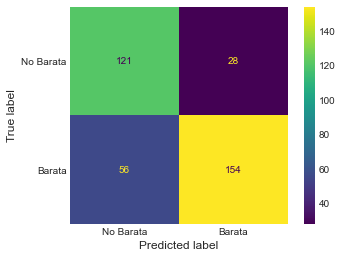

In [52]:
disp.plot()
plt.show()

En la matriz de confusión anterior se puede observar que el modelo identificó 56 falsos negativos, es decir aquellas casas que clasificó como no baratas pero sí eran baratas, y también cuenta con 28 falsos positivos, son aquellas casas que identificó como baratas y no lo eran. La información propocionada por la matriz de confusión se encuntra muy alineada a la información presentada en el resumen anterior ya que en general el modelo se equivoca más al moemento  de identificar casas no baratas. 

Los errores en este caso, como ya se ha mencionado, le permiten al modelo aprender, y eso como respuesta al usuario también le indica que el modelo es capaz de continuar aprendiendo, sin embargo, debido a que aquí la mayor cantidad de errores se generan en la casas que no son baratas, una posible opción con la cual se podría entrenar de mejor forma el modelo sería utilizando validación cruzada, así se permite que el modelo se entrene y pruebe con todos los datos a disposición y sea capaz, de que en cada iteración de la validación cruzada, aprenda de sus errores anteriores y los "enmiende".


# Comparación de eficiencia
Compare la eficiencia de los 3 modelos que creó (uno para barata, otro para media y otro para cara) ¿Cuál se demoró más en procesar?¿Cuál se equivocó más?¿Cuál se equivocó menos?¿por qué?

Al comparar la eficiencia de procesamiento mediante el tiempo medido por los chunks de ejecución, de los tres modelos de creados, se pudo encontrar que el más rápido de los tres fue el que se creó para las casas de tipo cara, ya que este se tardó tan solo 42ms, a diferencia del modelo para las casa intermedias, el tardo 57ms y el de las casas baratas tardó 183ms. Por lo tal,  en cuanto a tiempo de ejecución, el mejor modelo creado fue para las casas caras.

Por otro lado, como se puede observar en los apartados anteriores, y como se comentó al evaluar la eficiencia de los modelos, el modelo que menos se equivocó fue el creado para las casas caras, esto puede ser explicado debido a que en el entrenamiento de cada modelo se utilizaron los mismos predictores, sin embargo, en el resumen de dichos modelos se pueden observar que para las casas de tipos intermedia y baratas existen predictores que no aportan información significativa a los modelos, empero, debido a que uno de los objetivos principales de esta hoja era la comparación entre cada uno de los modelos creados, no se eliminaron dichos predictores. 

Por otro lado, algo interesante también a tomar en consideración es que el modelo de las casas caras pudo haber sido el que menos se equivocó debido a que dentro del conjunto de datos es el tipo de casas del cual existen una mayor cantidad de observaciones, a diferencia del modelo en el que más se equivocó al predecir, el cual fue en las casas intermedias, el cual, de las 839 observaciones que se tienen únicamente 106 son intermedias, esto podría explicar que con una poca cantidad de datos, el modelo no es capaz de aprender lo suficientemente bien como para hacer predicciones más acertadas. Esto también se puede ver reflejado al encontrar que el modelo, según la matriz de confusión y el resumen de eficiente obtenido en los apartados anteriores, de las casas baratas es mejor, en cuanto a exactitud que el modelo de casas intermedias, y de igual forma, existe una mayor cantidad de casas baratas que de intermedias en el conjunto de datos.

Una posible solución para lograr que sin importar la cantidad de datos que se tengan que correspondan a la variable objetivo, el modelo sea capaz de predecir adecuadamente, sería optar por realizar validación cruzada, de con al menos 10 iteraciones o bloques y así no solo se ganratiza que no existe *overfitting* en el modelo, sino también que el modelo está siendo entrenado por todos los datos disponibles dentro del conjunto, y al hacer predicciones aprender de los errores cometidos y logra hacer mejores predicciones futuras. Otra recomendación que si bien no es viable para este conjunto de datos, es contar con una cantidad significativa, aproximidamente un 43% o más del total de observaciones, de observaciones que pertenezcan a la categoría de la variable objetivo, ya que así el modelo será capaz de aprender a reconocer las características de este grupo y podrá hacer mejores predicciones. 

